# SIT744 Practical 9: ResNet
 

*Dr Wei Luo*

<div class="alert alert-info">
We suggest that you run this notebook using Google Colab.
</div>


## Pre-practical readings

- [Writing custom layers and models with Keras](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

By now you should be familiar with the classical ConvNet architectures. In this practical, you will practice building deep models with more layers using residual units.



## Task 1 Keras ImageDataGenerator

We will continue using the *cats vs dogs* dataset in this practical. This time, we will be more serious about data augmentation by using Keras's `ImageDataGenerator`. This allows us to use a variety of predefined types of data augmentation. For this to work, we have to organise training and test images into folders.


In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

import os
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()





--2020-05-08 02:34:18--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   108MB/s    in 0.6s    

2020-05-08 02:34:19 (108 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Take a look into the folder `/tmp/cats_and_dogs_filtered` and see how the images are organised.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

`ImageDataGenerator` contains a collection of data augmentation operations. It works with the function `flow_from_directory` to create an input pipeline.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

IMAGE_SIZE = 100
BATCH_SIZE = 32

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # All images will be resized to 150x150
        batch_size=BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**exercise** Read the documentation for `ImageDataGenerator` and understand what data-augmentation operations are defined. Experiment with different configurations and see what each data augmentation does.


## Task 2 ResNet

We have seen VGG in the last two weeks. VGG has a very classical ConvNet architecture. Compared with VGG, ResNets can go much deeper, achieve a much higher classification accuracy, and is easier to train. Moreover, ResNets have a surprisingly simple architecture. At the centre is a repetition of multiple **residual units**.

A ResNet contains two types of residual units, depending on whether subsampling happens (stride>1).
![Residual units (src: d2l)](https://d2l.ai/_images/resnet-block.svg)

Subsampling happens at the first of the two convolutional layers. When the first convolutional layer has stride 1, the skip connection is just a pass-through. Otherwise, the skip connection is replaced with a 1x1 convolution layer of the matching stride setting (Note that this is no longer an identity mapping).


### Write custom layers

Here we define a ResidualUnit layer subclassing `keras.layers.Layer`. A layer defines a transformation from the input to the output, parametrised by the layer weights.

In [0]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", 
                        use_bias=False,
                        kernel_regularizer=keras.regularizers.l2(0.01)
                        )

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

### Write the custom model

Now we have a custom layer for the residual unit. We will build a relatively shallow ResNet.

In [0]:
model = keras.models.Sequential()

prev_filters = 64
c = [prev_filters, 2*prev_filters, 4*prev_filters, 4*prev_filters]
model.add(DefaultConv2D(c[0], 
                        input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
model.add(ResidualUnit(c[0], strides=1))
model.add(ResidualUnit(c[1], strides=2))
model.add(ResidualUnit(c[2], strides=2))
model.add(ResidualUnit(c[3], strides=2))
model.add(keras.layers.MaxPool2D(pool_size=(4, 4)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation="sigmoid"))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1728      
_________________________________________________________________
residual_unit (ResidualUnit) (None, 100, 100, 64)      74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 50, 50, 128)       230912    
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 25, 25, 256)       920576    
_________________________________________________________________
residual_unit_3 (ResidualUni (None, 13, 13, 256)       1248256   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

### Train the model

Training will be just like for any Keras model. Because our input data is from a Keras input pipeline (generator), we have to specify how many steps per epoch.  

In [0]:
%%time 

from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 33s 331ms/step - loss: 18.4898 - acc: 0.5685 - val_loss: 18.0816 - val_acc: 0.5025
Epoch 2/30
100/100 [==============================] - 31s 314ms/step - loss: 17.7326 - acc: 0.6285 - val_loss: 17.6064 - val_acc: 0.4929
Epoch 3/30
100/100 [==============================] - 32s 317ms/step - loss: 16.9715 - acc: 0.6454 - val_loss: 16.5989 - val_acc: 0.5495
Epoch 4/30
100/100 [==============================] - 31s 314ms/step - loss: 16.1760 - acc: 0.6515 - val_loss: 16.1210 - val_acc: 0.5161
Epoch 5/30
100/100 [==============================] - 32s 316ms/step - loss: 15.2930 - acc: 0.6680 - val_loss: 14.8053 - val_acc: 0.6707
Epoch 6/30
100/100 [==============================] - 31s 313ms/step - loss: 14.3371 - acc: 0.6834 - val_loss: 13.8564 - val_acc: 0.6888
Epoch 7/30
100/100 [==============================] - 31s 314ms/step - loss: 13.3648 - acc: 0.6948 - val_loss: 12.8956 - val_acc: 0.6965
Epoch 8/30
100/100 [=====================

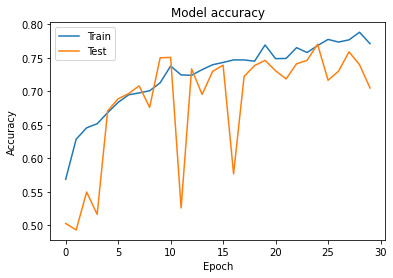

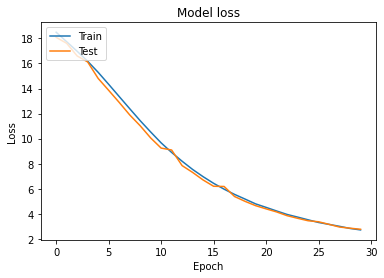

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**exercise** Try a different batch size. See if it affects the model performance and the training speed.

## Task 3 Depth Separable Convolution

In the lecture, we see that Depth Separable Convolution can be used to reduce the number of training parameters. We will explore the potential benefit of using depth separable convolution layers in a residual unit.

In [0]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", 
                        use_bias=False,
                        kernel_regularizer=keras.regularizers.l2(0.01)
                        )

DefaultSeparableConv2D = partial(keras.layers.SeparableConv2D, kernel_size=3, strides=1,
                                 padding="SAME", 
                                 use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(0.01))

class DepthwiseResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultSeparableConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultSeparableConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

model = keras.models.Sequential()

prev_filters = 64
c = [prev_filters, 2*prev_filters, 4*prev_filters, 4*prev_filters]
model.add(DefaultConv2D(c[0], 
                        input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
model.add(DepthwiseResidualUnit(c[0], strides=1))
model.add(DepthwiseResidualUnit(c[1], strides=2))
model.add(DepthwiseResidualUnit(c[2], strides=2))
model.add(DepthwiseResidualUnit(c[3], strides=2))
model.add(keras.layers.MaxPool2D(pool_size=(4, 4)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation="sigmoid"))



In [0]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_147 (Conv2D)          (None, 100, 100, 64)      1728      
_________________________________________________________________
depthwise_residual_unit_3 (D (None, 100, 100, 64)      9856      
_________________________________________________________________
depthwise_residual_unit_4 (D (None, 50, 50, 128)       36032     
_________________________________________________________________
depthwise_residual_unit_5 (D (None, 25, 25, 256)       137600    
_________________________________________________________________
depthwise_residual_unit_6 (D (None, 13, 13, 256)       204288    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2304)            

**question** How does the number of parameters change with the introduction of separable convolution layers?

In [0]:
%%time 

from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 35s 352ms/step - loss: 5.8376 - acc: 0.5792 - val_loss: 5.6987 - val_acc: 0.4961
Epoch 2/30
100/100 [==============================] - 34s 340ms/step - loss: 5.5966 - acc: 0.6212 - val_loss: 5.5073 - val_acc: 0.5019
Epoch 3/30
100/100 [==============================] - 34s 344ms/step - loss: 5.3827 - acc: 0.6367 - val_loss: 5.3182 - val_acc: 0.4949
Epoch 4/30
100/100 [==============================] - 34s 343ms/step - loss: 5.1690 - acc: 0.6633 - val_loss: 5.1385 - val_acc: 0.4942
Epoch 5/30
100/100 [==============================] - 34s 345ms/step - loss: 4.9772 - acc: 0.6755 - val_loss: 5.0312 - val_acc: 0.5057
Epoch 6/30
100/100 [==============================] - 34s 344ms/step - loss: 4.8043 - acc: 0.6742 - val_loss: 4.8503 - val_acc: 0.5251
Epoch 7/30
100/100 [==============================] - 34s 344ms/step - loss: 4.6375 - acc: 0.6693 - val_loss: 4.5603 - val_acc: 0.6662
Epoch 8/30
100/100 [==============================] - 3

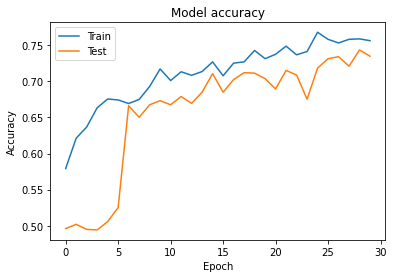

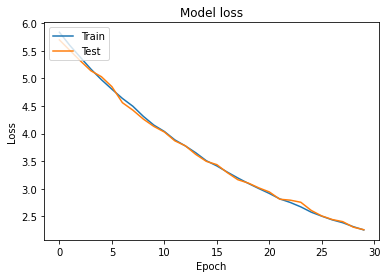

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**question** Do you see any performance improvement by using separable convolution layers? How about the difference in the training time?

**exercise** Continue the training of the above two models until they converge. What validation accuracy can you achieve?

## Additional resources

- David Page has authored a wonderful series of articles on [practical tips for training ResNets.](https://myrtle.ai/how-to-train-your-resnet/)